# Exploration of the UPenn PhotDec catalogs

The goal of this notebook is to play around with the data released by Meert et al. at  
http://alan-meert-website-aws.s3-website-us-east-1.amazonaws.com/fit_catalog/download/index.html

ToDo:
* Grab the SDSS photometry for the sample.

### Imports and paths

In [1]:
import os
import numpy as np

import fitsio
import matplotlib.pyplot as plt
from corner import corner

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# topdir = '/global/work/data/upenn-photdec'
topdir = '/Users/ioannis/research/data/upenn-photdec'
basicdir = os.path.join(topdir, 'basic-catalog', 'v2')
adddir = os.path.join(topdir, 'additional-catalogs')

### Model fitting results in grz
Read the model fitting results (in each band) and select a clean sample using the "finalflag" bit (see Section 2.2 of the `data_tables.pdf` documentation and Meert et al. 2015).

In [4]:
def select_meert(finalflag, n_bulge):
    """Select a good sample of targets."""
    noflags = finalflag & 11 != 0
    goodserexp = finalflag & 12 != 0
    flip = finalflag & 13 != 0
    smalln = n_bulge < 8

    good = np.logical_or(noflags, goodserexp)
    good = np.logical_or(good, flip)
    good = np.logical_and(good, smalln)

    isbulge = finalflag & 1 != 0
    isser = finalflag & 4 != 0
    isfit = np.logical_or(isbulge, isser)
    
    good = np.logical_and(good, isfit)
    
    return good

In [5]:
band = ['gband', 'rband', 'iband']

In [6]:
good = None
for thisband in band:
    measfile = os.path.join(basicdir, 'UPenn_PhotDec_NonParam_{}.fits'.format(thisband))
    measinfo = fitsio.FITS(measfile)
    fitfile = os.path.join(basicdir, 'UPenn_PhotDec_Models_{}.fits'.format(thisband))
    fitinfo = fitsio.FITS(fitfile)    
    _fit = fitinfo[1].read(columns=['finalflag', 'n_bulge'])
    _good = select_meert(_fit['finalflag'], _fit['n_bulge'])
    if good is None:
        print(measinfo[1])
        print(fitinfo[1])
        good = _good        
    else:
        good = np.logical_and(good, _good)
goodindx = np.where(good)[0]
nobj = len(goodindx)
print('Selected {}/{} good targets.'.format(nobj, len(_fit)))


  file: /Users/ioannis/research/data/upenn-photdec/basic-catalog/v2/UPenn_PhotDec_NonParam_gband.fits
  extension: 1
  type: BINARY_TBL
  rows: 670722
  column info:
    SexMag              f4  
    SexMag_Err          f4  
    SexHrad             f4  
    SexSky              f4  
    num_targets         i2  
    num_neighborfit     i2  
    AperRad             f4  
    C                   f4  
    C_err               f4  
    A                   f4  
    A_err               f4  
    S                   f4  
    S_err               f4  
    G                   f4  
    M20                 f4  
    extinction          f4  
    dismod              f4  
    kpc_per_arcsec      f4  
    Vmax                f4  
    SN                  f4  
    kcorr               f4  

  file: /Users/ioannis/research/data/upenn-photdec/basic-catalog/v2/UPenn_PhotDec_Models_gband.fits
  extension: 1
  type: BINARY_TBL
  rows: 670722
  column info:
    m_tot               f4  
    m_aper              f4  
 

In [7]:
fit, meas = [], []
for thisband in band:
    fitfile = os.path.join(basicdir, 'UPenn_PhotDec_Models_{}.fits'.format(thisband))
    measfile = os.path.join(basicdir, 'UPenn_PhotDec_NonParam_{}.fits'.format(thisband))
    fit.append(fitsio.read(fitfile, ext=1, rows=goodindx))
    meas.append(fitsio.read(measfile, ext=1, rows=goodindx))
gfit, rfit, ifit = fit
gmeas, rmeas, imeas = meas
del fit, meas

Also read the CAST catalog, which contains supplementary SDSS data.

In [8]:
castfile = os.path.join(basicdir, 'UPenn_PhotDec_CAST.fits')
castinfo = fitsio.FITS(castfile)
castinfo[1]


  file: /Users/ioannis/research/data/upenn-photdec/basic-catalog/v2/UPenn_PhotDec_CAST.fits
  extension: 1
  type: BINARY_TBL
  rows: 670722
  column info:
    galcount            i4  
    objid               i8  
    SDSSIAU            S24  
    badflag             i4  
    nchild              i2  
    mode                i2  
    run                 i2  
    rerun               i2  
    camCol              i2  
    field               i2  
    obj                 i2  
    stripe              i4  
    startmu             i4  
    specobjid           i8  
    plate               i2  
    mjd                 i4  
    fiberid             i2  
    ra                  f4  
    dec                 f4  
    z                   f4  
    veldisp             f4  
    veldispErr          f4  
    eclass              f4  
    p_el_debiased       f4  
    p_cs_debiased       f4  
    spiral              i4  
    elliptical          i4  
    uncertain           i4  

In [9]:
cast = castinfo[1].read(rows=np.where(good))

### Generate various diagnostic plots

In [10]:
print('r-band range = {:.3f} - {:.3f}'.format(rfit['m_tot'].min(), rfit['m_tot'].max()))
print('Redshift range = {:.4f} - {:.4f}'.format(cast['z'].min(), cast['z'].max()))

r-band range = 12.813 - 19.186
Redshift range = 0.0050 - 0.8317


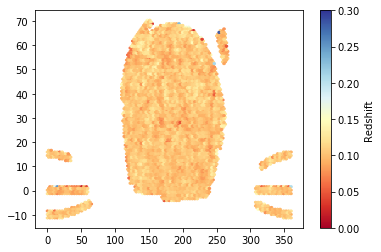

In [11]:
fig, ax = plt.subplots()
cm = plt.cm.get_cmap('RdYlBu')
hb = ax.hexbin(cast['ra'], cast['dec'], C=cast['z'], cmap=cm, 
               vmin=0, vmax=0.3)
cb = plt.colorbar(hb)
cb.set_label('Redshift')

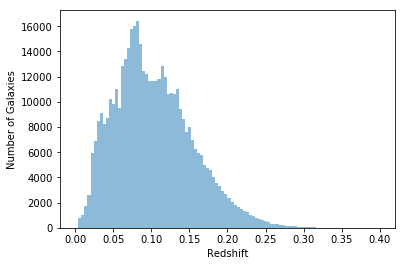

In [12]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(cast['z'], bins=100, range=(0, 0.4), alpha=0.5)
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of Galaxies')

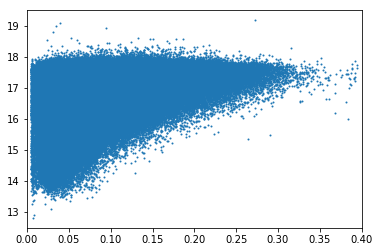

In [13]:
fig, ax = plt.subplots()
ax.scatter(cast['z'], rfit['m_tot'], s=1)
ax.set_xlim((0, 0.4))
ax.margins(0.05)

In [14]:
labels = ['r (AB mag)', 'g - r', 'Sersic n', 'Half-light Radius (arcsec)']
data = np.array([ rfit['m_tot'], gfit['m_tot'] - rfit['m_tot'], rfit['n_disk'], rfit['r_disk'] ]).T
data.shape

(445790, 4)

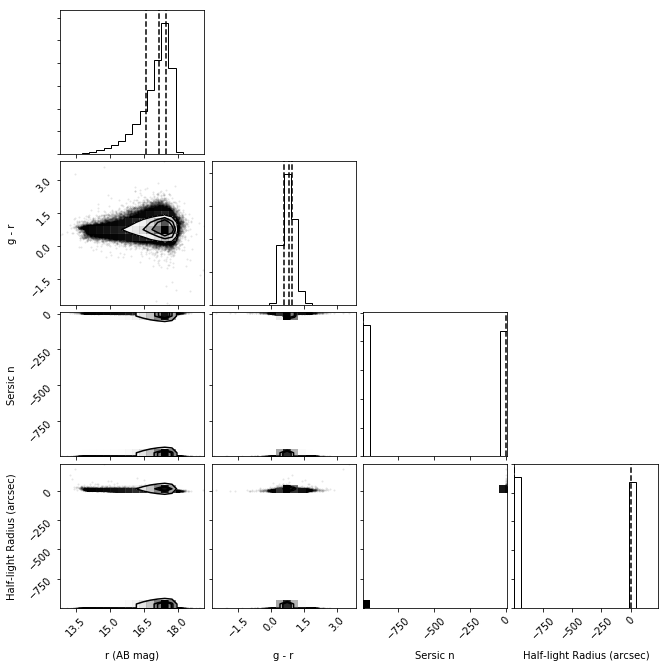

In [15]:
_ = corner(data, quantiles=[0.25, 0.50, 0.75], labels=labels)